### 라이브러리 및 데이터 불러오기


In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML
sns.set_style('darkgrid')

In [ ]:
#드라이브 마운트 및 데이터셋 임포트
from google.colab import drive
drive.mount('/content/drive')
log_data = pd.read_csv(r'/content/drive/MyDrive/data/log_data.csv')
loan_result = pd.read_csv(r'/content/drive/MyDrive/data/loan_result.csv')
user_spec = pd.read_csv(r'/content/drive/MyDrive/data/user_spec.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


부수적인 코드, 실행 필요 X

In [ ]:
train_loan5 = pd.read_csv(r'/content/drive/MyDrive/22-2 KUBIG 분류 예측 1팀/이수찬/train.csv')
test_loan4 = pd.read_csv(r'/content/drive/MyDrive/22-2 KUBIG 분류 예측 1팀/김상옥/test.csv')
train_loan5 = train_loan5.drop('Unnamed: 0', axis=1)
test_loan4 = test_loan4.drop('Unnamed: 0', axis=1)

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

### 1. 데이터셋 확인

####1-1. log_data  

  - 따라서 user_id가 같은 인덱스가 매우 많고, 단순하게 user_spec과 loan_result와 병합하면 비효율적일 것이라고 사료됨.


In [ ]:
#컬럼 정보 확인
log_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17843993 entries, 0 to 17843992
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   event           object
 2   timestamp       object
 3   mp_os           object
 4   mp_app_version  object
 5   date_cd         object
dtypes: int64(1), object(5)
memory usage: 816.8+ MB


In [ ]:
#결측치 비율 확인
log_data.isnull().sum()/len(log_data)

user_id           0.000000
event             0.000000
timestamp         0.000000
mp_os             0.000055
mp_app_version    0.037021
date_cd           0.000000
dtype: float64

In [ ]:
 #user_id 중복값 개수 확인
 log_data.duplicated(subset='user_id').sum()

17259357

In [ ]:
#수치형 변수 요약통계량
log_data.describe()

,user_id
count,1.784399e+07
mean,4.398264e+05
std,2.534944e+05
min,1.000000e+00
25%,2.212640e+05
50%,4.401280e+05
75%,6.588750e+05
max,8.796980e+05


In [ ]:
#범주형 변수 요약통계량 -> user_id 제외 모두 범주형 변수
log_data.describe(include=['O'])

,event,timestamp,mp_os,mp_app_version,date_cd
count,17843993,17843993,17843013,17183396,17843993
unique,11,6879764,4,259,122
top,OpenApp,2022-04-11 11:40:30,Android,3.14.0,2022-06-27
freq,3460762,23,12331688,2339899,267738


In [ ]:
log_data.head(20)

,user_id,event,timestamp,mp_os,mp_app_version,date_cd
0,576409,StartLoanApply,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
1,576409,ViewLoanApplyIntro,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
2,72878,EndLoanApply,2022-03-25 11:14:44,Android,3.8.4,2022-03-25
3,645317,OpenApp,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25
4,645317,UseLoanManage,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25
5,640185,UseLoanManage,2022-03-25 11:41:53,iOS,3.6.1,2022-03-25
6,640185,ViewLoanApplyIntro,2022-03-25 11:42:38,iOS,3.6.1,2022-03-25
7,640185,UsePrepayCalc,2022-03-25 11:43:07,iOS,3.6.1,2022-03-25
8,640185,UseLoanManage,2022-03-25 11:43:57,iOS,3.6.1,2022-03-25
9,640185,UseLoanManage,2022-03-25 11:44:04,iOS,3.6.1,2022-03-25


####1-2. user_spec

In [ ]:
#컬럼 정보 확인
user_spec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394216 entries, 0 to 1394215
Data columns (total 17 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   application_id                       1394216 non-null  int64  
 1   user_id                              1394216 non-null  int64  
 2   birth_year                           1381255 non-null  float64
 3   gender                               1381255 non-null  float64
 4   insert_time                          1394216 non-null  object 
 5   credit_score                         1289101 non-null  float64
 6   yearly_income                        1394126 non-null  float64
 7   income_type                          1394131 non-null  object 
 8   company_enter_month                  1222456 non-null  float64
 9   employment_type                      1394131 non-null  object 
 10  houseown_type                        1394131 non-null  object 
 11

In [ ]:
#결측치 비율 확인
user_spec.isnull().sum()

application_id                               0
user_id                                      0
birth_year                               12961
gender                                   12961
insert_time                                  0
credit_score                            105115
yearly_income                               90
income_type                                 85
company_enter_month                     171760
employment_type                             85
houseown_type                               85
desired_amount                              85
purpose                                     85
personal_rehabilitation_yn              587461
personal_rehabilitation_complete_yn    1203354
existing_loan_cnt                       198556
existing_loan_amt                       313774
dtype: int64

In [ ]:
#수치형 변수 요약통계량
user_spec.describe()

,application_id,user_id,birth_year,gender,credit_score,yearly_income,company_enter_month,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
count,1.394216e+06,1.394216e+06,1.381255e+06,1.381255e+06,1.289101e+06,1.394126e+06,1.222456e+06,1.394131e+06,806755.000000,190862.000000,1.195660e+06,1.080442e+06
mean,1.084044e+06,4.395663e+05,1.983285e+03,6.764290e-01,6.384447e+02,4.345326e+07,5.121685e+06,3.040726e+07,0.015753,0.007084,4.743685e+00,7.074593e+07
std,6.259020e+05,2.538436e+05,1.067367e+01,4.678386e-01,1.249724e+02,1.208401e+08,8.608381e+06,1.851687e+08,0.124519,0.083866,4.327669e+00,9.050560e+07
min,1.000000e+00,1.000000e+00,1.927000e+03,0.000000e+00,6.000000e+01,0.000000e+00,1.911090e+05,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000e+00
25%,5.417125e+05,2.203430e+05,1.976000e+03,0.000000e+00,5.700000e+02,2.500000e+07,2.019020e+05,5.000000e+06,0.000000,0.000000,2.000000e+00,2.200000e+07
50%,1.084263e+06,4.399795e+05,1.984000e+03,1.000000e+00,6.200000e+02,3.400000e+07,2.021060e+05,1.000000e+07,0.000000,0.000000,4.000000e+00,4.500000e+07
75%,1.625896e+06,6.590020e+05,1.992000e+03,1.000000e+00,6.900000e+02,4.800000e+07,2.022050e+05,3.000000e+07,0.000000,0.000000,6.000000e+00,8.300000e+07
max,2.167826e+06,8.796970e+05,2.008000e+03,1.000000e+00,1.000000e+03,1.000000e+10,2.022063e+07,1.000000e+10,1.000000,1.000000,2.780000e+02,7.512000e+09


In [ ]:
#범주형 변수 요약통계량
user_spec.describe(include=['O'])

,insert_time,income_type,employment_type,houseown_type,purpose
count,1394216,1394131,1394131,1394131,1394131
unique,1265510,6,4,4,16
top,2022-05-09 14:18:08,EARNEDINCOME,정규직,전월세,생활비
freq,7,892579,918032,642838,866079


####1-3. loan_result

In [ ]:
#컬럼 정보 확인
loan_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527363 entries, 0 to 13527362
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   application_id         int64  
 1   loanapply_insert_time  object 
 2   bank_id                int64  
 3   product_id             int64  
 4   loan_limit             float64
 5   loan_rate              float64
 6   is_applied             float64
dtypes: float64(3), int64(3), object(1)
memory usage: 722.4+ MB


In [ ]:
#결측치 비율 확인
loan_result.isnull().sum()

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                  7495
loan_rate                   7495
is_applied               3257239
dtype: int64

In [ ]:
# 수치형 변수 요약통계량
loan_result.describe()

,application_id,bank_id,product_id,loan_limit,loan_rate,is_applied
count,1.352736e+07,1.352736e+07,1.352736e+07,1.351987e+07,1.351987e+07,1.027012e+07
mean,1.083520e+06,3.259900e+01,1.464136e+02,2.274095e+07,1.275172e+01,5.457081e-02
std,6.260518e+05,1.725680e+01,7.866002e+01,7.221901e+07,3.843386e+00,2.271406e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.500000e+00,0.000000e+00
25%,5.415640e+05,1.900000e+01,7.100000e+01,9.000000e+06,9.600000e+00,0.000000e+00
50%,1.083953e+06,3.400000e+01,1.500000e+02,1.800000e+07,1.320000e+01,0.000000e+00
75%,1.625316e+06,4.600000e+01,2.170000e+02,3.300000e+07,1.560000e+01,0.000000e+00
max,2.167826e+06,6.400000e+01,2.700000e+02,2.308000e+11,2.000000e+01,1.000000e+00


In [ ]:
#범주형 변수 요약통계량
loan_result.describe(include=['O'])

,loanapply_insert_time
count,13527363
unique,3220564
top,2022-05-10 18:06:33
freq,61


In [ ]:
#타겟 변수 확인
loan_result['is_applied']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
            ..
13527358   NaN
13527359   NaN
13527360   NaN
13527361   NaN
13527362   NaN
Name: is_applied, Length: 13527363, dtype: float64

###2. 트레인/테스트 셋 추출
단, loan_result 기준으로 user_spec하고만 병합

In [ ]:
#usr_spec에서 user_id와 application 중복값 개수 확인->값이 모두 고유함
user_spec.duplicated(['user_id','application_id']).sum()

0

In [ ]:
#user_spec에서 appliction_id 중복값 개수 확인
user_spec.duplicated(['application_id']).sum()

0

In [ ]:
#최종 제출 데이터셋에서 product_id와 application_id가 키가 되므로 겹치는 건 제거
loan_result.duplicated(['product_id','application_id']).sum()

906

In [ ]:
#중복 데이터 제거
loan_result = loan_result.drop_duplicates()
user_spec = user_spec.drop_duplicates()
log_data = log_data.drop_duplicates()

In [ ]:
#대출신청 데이터가 NaN이 아니면 train, 
#이에 해당하는 대출신청서(application_id), 사용자(user_id)가 있는 세트를 추출
train_loan = loan_result[loan_result['is_applied'].notnull()]
train_user = user_spec.loc[user_spec['application_id'].isin(train_loan['application_id'])]
train_log = log_data.loc[log_data['user_id'].isin(train_user['user_id'])]

In [ ]:
#대출신청 데이터가 NaN이면 test, 
#이에 해당하는 대출신청서(application_id), 사용자(user_id)가 있는 세트를 추출
test_loan = loan_result[loan_result['is_applied'].isna()]
test_user = user_spec.loc[user_spec['application_id'].isin(test_loan['application_id'])]
test_log = log_data.loc[log_data['user_id'].isin(test_user['user_id'])]

In [ ]:
#loan_result를 기준으로 user_spec과 병합
test_loan = pd.merge(test_loan, test_user, on='application_id', how='left')
train_loan = pd.merge(train_loan, train_user, on='application_id', how='left')

In [ ]:
#application_id, product_id 중복값 제거
test_loan = test_loan.drop_duplicates(['application_id','product_id'])

In [ ]:
#application_id, product_id 중복값 제거
train_loan = train_loan.drop_duplicates(['application_id','product_id'])

In [ ]:
#데이터프레임 크기 
print(loan_result.shape, user_spec.shape, log_data.shape)
print(test_loan.shape, test_user.shape, test_log.shape)
print(train_loan.shape, train_user.shape, train_log.shape)

(13527337, 7) (1394216, 17) (17359850, 6)
(3257034, 23) (239949, 17) (7332541, 6)
(10269424, 23) (728884, 17) (12761541, 6)


###3. loan_result & user_spec EDA

####3-1. 기초통계량&분포

In [ ]:
#수치형 변수 기초통계량
pd.options.display.float_format = '{:.1f}'.format
train_loan.describe()

,application_id,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,credit_score,yearly_income,company_enter_month,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
count,10269424.0,10269424.0,10269424.0,10263894.0,10263894.0,10269424.0,10269311.0,10177687.0,10177687.0,9025576.0,10269311.0,9965769.0,10269311.0,4396622.0,1037741.0,8125613.0,7225324.0
mean,1083173.2,32.8,146.1,22608102.3,12.8,0.1,440277.2,1982.8,0.7,750.1,47919529.0,201774.1,51593472.0,0.0,0.0,3.6,81674592.7
std,625814.8,17.2,78.2,22307452.7,3.9,0.2,253861.9,9.6,0.5,127.5,131879764.9,542.7,232347570.2,0.1,0.1,3.1,98242280.1
min,1.0,1.0,1.0,0.0,1.5,0.0,9.0,1930.0,0.0,100.0,0.0,191109.0,0.0,0.0,0.0,1.0,0.0
25%,541815.0,19.0,71.0,9000000.0,9.5,0.0,221242.0,1976.0,0.0,650.0,29000000.0,201701.0,10000000.0,0.0,0.0,1.0,25000000.0
50%,1083348.0,34.0,150.0,18000000.0,13.2,0.0,440314.0,1984.0,1.0,730.0,36000000.0,202003.0,28000000.0,0.0,0.0,3.0,49000000.0
75%,1624473.0,47.0,216.0,33000000.0,15.8,0.0,661214.0,1990.0,1.0,860.0,50000000.0,202107.0,50000000.0,0.0,0.0,5.0,96000000.0
max,2167826.0,64.0,270.0,10000000000.0,20.0,1.0,879697.0,2003.0,1.0,1000.0,10000000000.0,202211.0,10000000000.0,1.0,1.0,178.0,7512000000.0


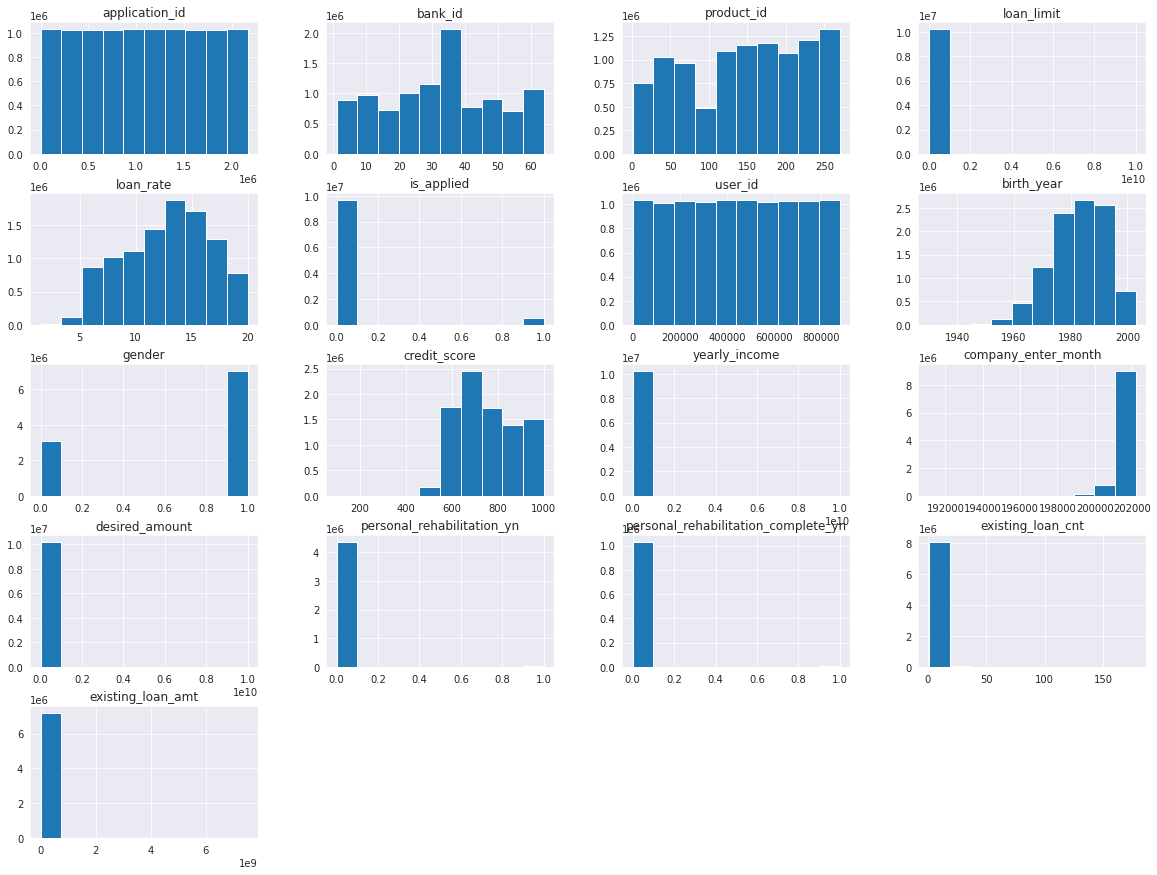

In [ ]:
#수치형 데이터 분포
train_loan.hist(bins=10, figsize=(20,15))
plt.show()

In [ ]:
#명목형 변수 기초통계량
train_loan.describe(include=['O'])

,loanapply_insert_time,insert_time,income_type,employment_type,houseown_type,purpose
count,10269424,10269311,10269311,10269311,10269311,10269311
unique,2427999,681159,6,4,4,16
top,2022-05-10 18:06:33,2022-05-13 13:01:06,EARNEDINCOME,정규직,전월세,생활비
freq,61,159,8715180,8398240,4593972,5155996


In [ ]:
plt.rc('font', family='NanumBarunGothic') 

<AxesSubplot:xlabel='count', ylabel='income_type'>

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  func(*args, **kw

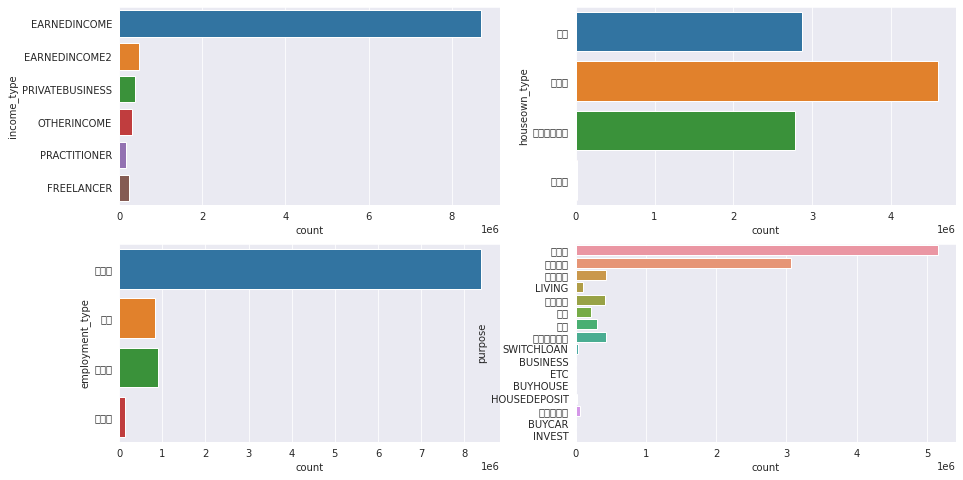

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.countplot(y='employment_type',data=train_loan, ax=axes[1,0])
sns.countplot(y='houseown_type',data=train_loan, ax=axes[0,1])
sns.countplot(y='purpose',data=train_loan, ax=axes[1,1])
sns.countplot(y='income_type',data=train_loan, ax=axes[0,0])

####3-2. 상관관계

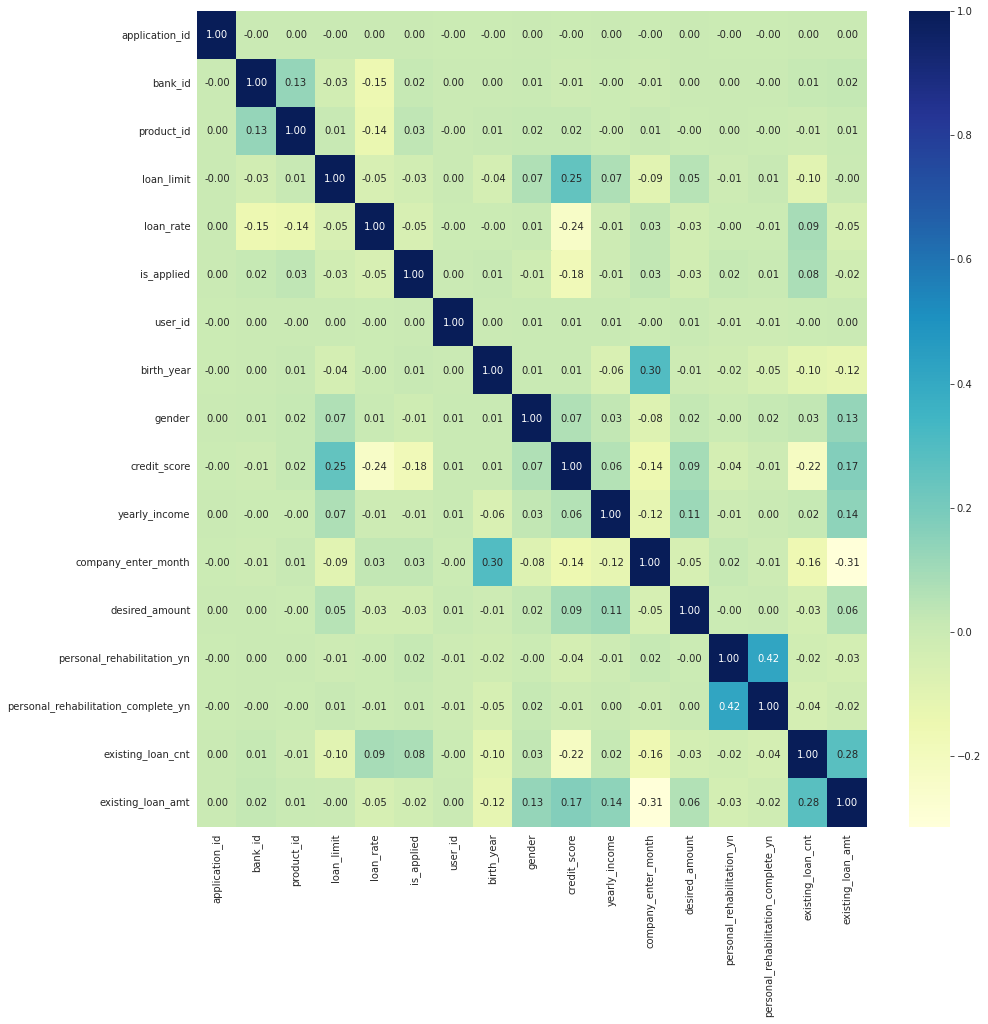

In [ ]:
#상관관계 plot(너무 커서 수치는 제거)
df_corr=train_loan.corr()
plt.figure(figsize=(15,15))
sns.heatmap(df_corr,annot=True,fmt = '.2f',cmap='YlGnBu')

In [ ]:
cor = df_corr
cor = cor.reset_index()
cor.head()

,index,application_id,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,credit_score,yearly_income,company_enter_month,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
0,application_id,1.000000,-0.000444,0.000288,-0.000477,0.000481,0.000414,-0.000910,-0.002602,0.000765,-0.001488,0.001152,-0.001914,0.002388,-0.001115,-0.004199,0.001693,0.002167
1,bank_id,-0.000444,1.000000,0.129006,-0.030149,-0.150258,0.015890,0.000214,0.003801,0.008997,-0.007920,-0.000810,-0.006199,0.000080,0.004030,-0.000118,0.014830,0.024135
2,product_id,0.000288,0.129006,1.000000,0.009805,-0.137451,0.034724,-0.000057,0.011899,0.015333,0.016777,-0.004200,0.013226,-0.000799,0.001615,-0.002116,-0.007414,0.006344
3,loan_limit,-0.000477,-0.030149,0.009805,1.000000,-0.053341,-0.029381,0.003194,-0.037802,0.068668,0.252913,0.074050,-0.093870,0.050682,-0.009330,0.010611,-0.097881,-0.000214
4,loan_rate,0.000481,-0.150258,-0.137451,-0.053341,1.000000,-0.052436,-0.001923,-0.002732,0.007804,-0.238353,-0.006318,0.029012,-0.030496,-0.004153,-0.005592,0.090952,-0.049032


In [ ]:
#타겟변수와 높은 상관관계 안 보임
cor[['index','is_applied']]

,index,is_applied
0,application_id,0.000414
1,bank_id,0.015890
2,product_id,0.034724
3,loan_limit,-0.029381
4,loan_rate,-0.052436
5,is_applied,1.000000
6,user_id,0.000221
7,birth_year,0.010701
8,gender,-0.012276
9,credit_score,-0.176663


In [ ]:
#서로 상관계수 0.3 이상인 변수 확인
name = list(cor['index'])
multi = []
for i in name:
  ind1 = cor[(cor[i] > 0.3) | (cor[i] < -0.3)]
  ind2 = list(ind1['index'])
  ind2.remove(i)  
  if len(ind2) > 0: 
      print(i, ind2)
      multi.append(i)

company_enter_month ['existing_loan_amt']
personal_rehabilitation_yn ['personal_rehabilitation_complete_yn']
personal_rehabilitation_complete_yn ['personal_rehabilitation_yn']
existing_loan_amt ['company_enter_month']


###4. loan_result & user_spec 전처리

####4-1.결측치 파악 & 트레인 결측행 제거

In [ ]:
#결측치가 하나라도 있는 행을 리스트로 기록
test_na = test_loan.columns[test_loan.isnull().sum() > 0].values
train_na = train_loan.columns[train_loan.isnull().sum() > 0].values

In [ ]:
#결측치 유형 체크
na_train = list(set(train_na) - set(test_na))
na_test = list(set(train_na) - (set(train_na) - set(test_na)))

print("train에서만 결측(결측 인덱스 삭제 가능):\n", na_train)
print("양쪽 다 결측(인덱스 삭제 불가, 대치하거나 column 삭제하거나):\n", na_test)

train에서만 결측(결측 인덱스 삭제 가능):
 ['income_type', 'purpose', 'houseown_type', 'user_id', 'employment_type', 'desired_amount', 'insert_time']
양쪽 다 결측(인덱스 삭제 불가, 대치하거나 column 삭제하거나):
 ['yearly_income', 'company_enter_month', 'existing_loan_cnt', 'credit_score', 'existing_loan_amt', 'personal_rehabilitation_yn', 'birth_year', 'loan_rate', 'personal_rehabilitation_complete_yn', 'gender', 'loan_limit']


In [ ]:
#train에만 있는 결측치 비율
pd.options.display.float_format = '{:.6f}'.format
train_loan[na_train].isnull().sum()/len(train_loan)

income_type       0.000011
purpose           0.000011
houseown_type     0.000011
user_id           0.000011
employment_type   0.000011
desired_amount    0.000011
insert_time       0.000011
dtype: float64

In [ ]:
#둘 다 있는 결측치 비율(train)
train_loan[na_test].isnull().sum()/len(train_loan)

yearly_income                         0.000011
company_enter_month                   0.029569
existing_loan_cnt                     0.208757
credit_score                          0.121121
existing_loan_amt                     0.296424
personal_rehabilitation_yn            0.571873
birth_year                            0.008933
loan_rate                             0.000538
personal_rehabilitation_complete_yn   0.898948
gender                                0.008933
loan_limit                            0.000538
dtype: float64

In [ ]:
#둘 다 있는 결측치 비율(test)
test_loan[na_test].isnull().sum()/len(test_loan)

yearly_income                         0.000002
company_enter_month                   0.029711
existing_loan_cnt                     0.166373
credit_score                          0.081502
existing_loan_amt                     0.259744
personal_rehabilitation_yn            0.004750
birth_year                            0.011197
loan_rate                             0.000532
personal_rehabilitation_complete_yn   0.786477
gender                                0.011197
loan_limit                            0.000532
dtype: float64

In [ ]:
#train에만 있는 결측치 제거 후 train set 변화, 크지 않으므로 그대로 진행
train_loan1 = train_loan.dropna(subset=na_train)
train_loan1 = train_loan1.dropna(subset=['loan_rate', 'loan_limit'])
test_loan = test_loan.dropna(subset=['loan_rate', 'loan_limit'])
print(train_loan.shape, train_loan1.shape, test_loan.shape)

(10269424, 23) (10263894, 23) (3255302, 23)


####4-2 개인회생 변수에 '무응답' 추가 -> 완료, 미완료 더미변수화

In [ ]:
#personal_rehabilitation 시리즈는 yes(1) or no(0)이기 때문에 범주형으로 변환, 결측치는 무응답(none)으로 대치
train_loan2 = train_loan1.replace({'personal_rehabilitation_yn': 0}, {'personal_rehabilitation_yn': 'no'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_yn': 1}, {'personal_rehabilitation_yn': 'yes'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_yn': np.nan}, {'personal_rehabilitation_yn': 'none'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_complete_yn': 0}, {'personal_rehabilitation_complete_yn': 'no'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_complete_yn': 1}, {'personal_rehabilitation_complete_yn': 'yes'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_complete_yn': np.nan}, {'personal_rehabilitation_complete_yn': 'none'})

#테스트 셋에도 적용
test_loan1 = test_loan.replace({'personal_rehabilitation_yn': 0}, {'personal_rehabilitation_yn': 'no'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_yn': 1}, {'personal_rehabilitation_yn': 'yes'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_yn': np.nan}, {'personal_rehabilitation_yn': 'none'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_complete_yn': 0}, {'personal_rehabilitation_complete_yn': 'no'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_complete_yn': 1}, {'personal_rehabilitation_complete_yn': 'yes'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_complete_yn': np.nan}, {'personal_rehabilitation_complete_yn': 'none'})

train_loan2['rehabilitation_complete'] = np.where(train_loan2['personal_rehabilitation_complete_yn']=='yes', 1, 0)
train_loan2['rehabilitation_incomplete'] = np.where(train_loan2['personal_rehabilitation_complete_yn']=='no', 1, 0)

train_loan2 = train_loan2.drop(columns = ['personal_rehabilitation_yn','personal_rehabilitation_complete_yn'])

test_loan1['rehabilitation_complete'] = np.where(test_loan1['personal_rehabilitation_complete_yn']=='yes', 1, 0)
test_loan1['rehabilitation_incomplete'] = np.where(test_loan1['personal_rehabilitation_complete_yn']=='no', 1, 0)

test_loan1 = test_loan1.drop(columns = ['personal_rehabilitation_yn','personal_rehabilitation_complete_yn'])

In [ ]:
#trian 데이터에서 'rehabilitation_complete','rehabilitation_incomplete' 변수 고유값 확인
train_loan2[['rehabilitation_complete','rehabilitation_incomplete']].value_counts()

rehabilitation_complete  rehabilitation_incomplete
0                        0                            9226739
                         1                            1033045
1                        0                               4110
dtype: int64

In [ ]:
#test 데이터에서 'rehabilitation_complete','rehabilitation_incomplete' 변수 고유값 확인
test_loan1[['rehabilitation_complete','rehabilitation_incomplete']].value_counts()

rehabilitation_complete  rehabilitation_incomplete
0                        0                            2560141
                         1                             692628
1                        0                               2533
dtype: int64

####4-3. 로그변환

In [ ]:
outlier = ['loan_limit','yearly_income','desired_amount','existing_loan_cnt','existing_loan_amt']

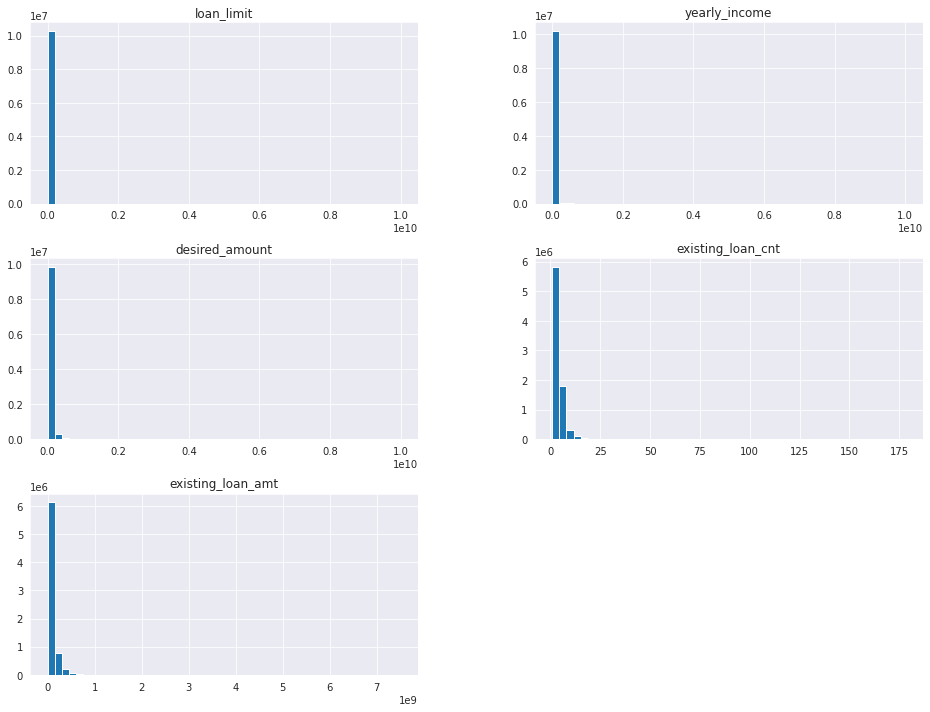

In [ ]:
#로그변환 이전 분포
train_loan2[outlier].hist(bins=50, figsize=(16,12))
plt.semilogy(base=2)
plt.show()

In [ ]:
#로그 변환
train_loan2[outlier] = np.log1p(train_loan1[outlier])
test_loan1[outlier] = np.log1p(test_loan[outlier])

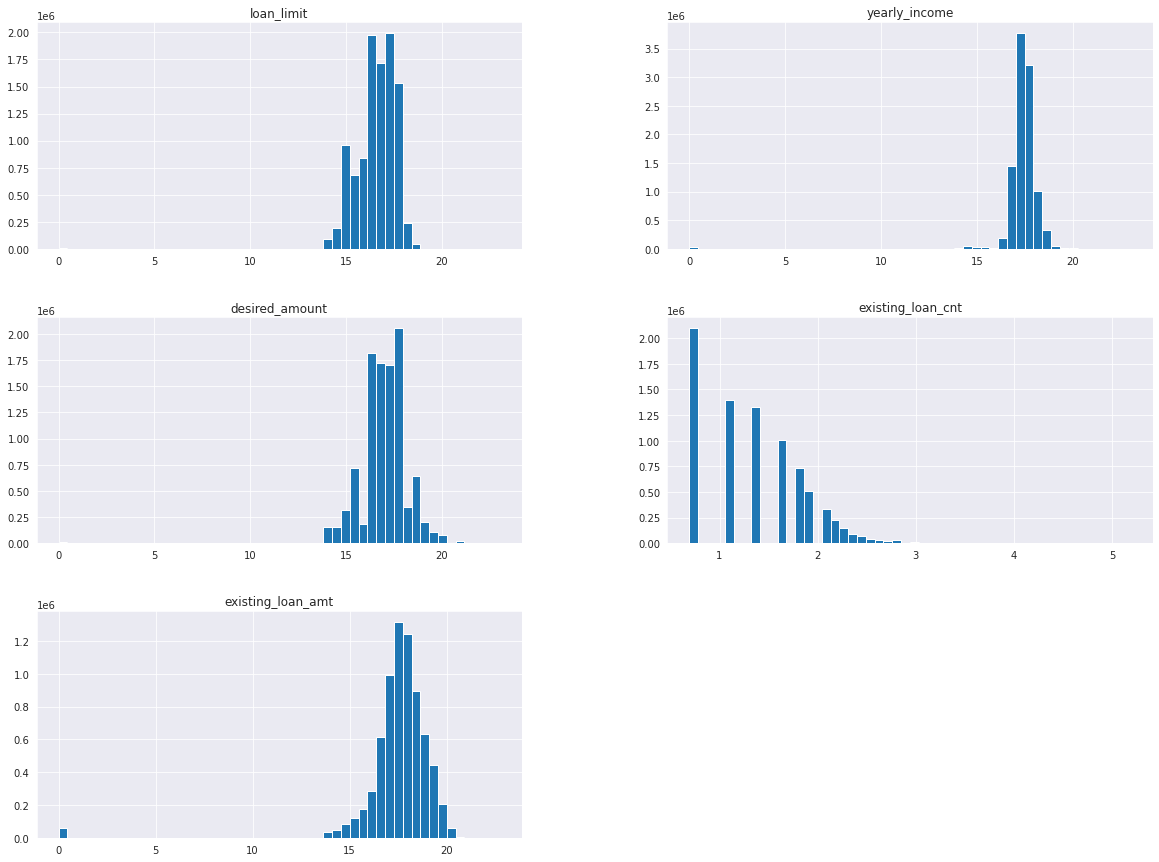

In [ ]:
#로그변환 이후 분포
train_loan2[outlier].hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
#요약통계량 확인
train_loan2[outlier].describe()

,loan_limit,yearly_income,desired_amount,existing_loan_cnt,existing_loan_amt
count,10263894.000000,10263894.000000,10263894.000000,8120917.000000,7220987.000000
mean,16.551870,17.408440,16.947078,1.375866,17.532698
std,1.021785,1.092327,1.330801,0.546048,1.955228
min,0.000000,0.000000,0.000000,0.693147,0.000000
25%,16.012735,17.182806,16.118096,0.693147,17.034386
50%,16.705882,17.399030,17.147715,1.386294,17.707331
75%,17.312018,17.727534,17.727534,1.791759,18.390222
max,23.025851,23.025851,23.025851,5.187386,22.739768


In [ ]:
#요약통계량 확인
test_loan1[outlier].describe()

,loan_limit,yearly_income,desired_amount,existing_loan_cnt,existing_loan_amt
count,3255302.000000,3255296.000000,3255302.000000,2713644.000000,2409619.000000
mean,16.568989,17.365063,16.963625,1.350041,17.496488
std,1.048925,1.508464,1.389202,0.541684,2.044883
min,0.000000,0.000000,0.000000,0.693147,0.000000
25%,16.012735,17.216708,16.118096,0.693147,17.034386
50%,16.705882,17.426428,17.216708,1.386294,17.686712
75%,17.312018,17.727534,17.727534,1.791759,18.379859
max,26.164817,23.025851,23.025851,5.438079,21.930733


####4-0.원핫인코딩

In [ ]:
#컬럼 정보 확인
train_loan2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10263894 entries, 0 to 10270113
Data columns (total 23 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   application_id             int64  
 1   loanapply_insert_time      object 
 2   bank_id                    int64  
 3   product_id                 int64  
 4   loan_limit                 float64
 5   loan_rate                  float64
 6   is_applied                 float64
 7   user_id                    float64
 8   birth_year                 float64
 9   gender                     float64
 10  insert_time                object 
 11  credit_score               float64
 12  yearly_income              float64
 13  income_type                object 
 14  company_enter_month        float64
 15  employment_type            object 
 16  houseown_type              object 
 17  desired_amount             float64
 18  purpose                    object 
 19  existing_loan_cnt          float64
 20  

In [ ]:
#train 데이터 결측치 개수 확인
train_loan2[['income_type','employment_type','houseown_type','purpose']].isnull().sum()

income_type        0
employment_type    0
houseown_type      0
purpose            0
dtype: int64

In [ ]:
# test 데이터 결측치 개수 확인
test_loan1[['income_type','employment_type','houseown_type','purpose']].isnull().sum()

income_type        0
employment_type    0
houseown_type      0
purpose            0
dtype: int64

In [ ]:
#고유값 확인
train_loan2[['income_type','employment_type','houseown_type','purpose']].value_counts()

income_type      employment_type  houseown_type  purpose   
EARNEDINCOME     정규직              전월세            생활비           1610979
                                  자가             생활비           1203344
                                  기타가족소유         생활비           1073757
                                  전월세            대환대출          1065617
                                  자가             대환대출           678114
                                                                ...   
OTHERINCOME      계약직              전월세            BUSINESS            1
                 정규직              기타가족소유         자동차구입               1
FREELANCER       정규직              배우자            SWITCHLOAN          1
PRACTITIONER     일용직              기타가족소유         자동차구입               1
PRIVATEBUSINESS  기타               전월세            ETC                 1
Length: 833, dtype: int64

In [ ]:
#train 데이터 범주형 변수 원핫인코딩
train_cat = train_loan2[['income_type','employment_type','houseown_type','purpose']]
train_catd = pd.get_dummies(train_cat, drop_first=False, dtype=int)
train_catd.head()

,income_type_EARNEDINCOME,income_type_EARNEDINCOME2,income_type_FREELANCER,income_type_OTHERINCOME,income_type_PRACTITIONER,income_type_PRIVATEBUSINESS,employment_type_계약직,employment_type_기타,employment_type_일용직,employment_type_정규직,...,purpose_LIVING,purpose_SWITCHLOAN,purpose_기타,purpose_대환대출,purpose_사업자금,purpose_생활비,purpose_자동차구입,purpose_전월세보증금,purpose_주택구입,purpose_투자
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
train_loan3 = train_loan2.drop(list(train_cat.columns), axis=1)
train_loan3 = pd.concat([train_loan3, train_catd], axis=1)

In [ ]:
#test 데이터 범주형 변수 원핫인코딩
test_cat = test_loan1[['income_type','employment_type','houseown_type','purpose']]
test_catd = pd.get_dummies(test_cat, drop_first=False,dtype=int)
test_loan2 = test_loan1.drop(list(test_cat.columns), axis=1)
test_loan2 = pd.concat([test_loan2, test_catd], axis=1)

In [ ]:
#문자열 추출
train_loan3['insert_time'] = train_loan3['insert_time'].str[0:10]
#train_loan3['loanapply_insert_time'] = train_loan3['loanapply_insert_time'].str[0:10]
test_loan2['insert_time'] = test_loan2['insert_time'].str[0:10]
#test_loan2['loanapply_insert_time'] = test_loan2['loanapply_insert_time'].str[0:10]

In [ ]:
#train_loan3[['insert_time','loanapply_insert_time']].head()

In [ ]:
#datetime 자료형으로 변환
train_loan3['insert_time'] = pd.to_datetime(train_loan3['insert_time'])
#train_loan3['loanapply_insert_time'] = pd.to_datetime(train_loan3['loanapply_insert_time'])
test_loan2['insert_time'] = pd.to_datetime(test_loan2['insert_time'])
#test_loan2['loanapply_insert_time'] = pd.to_datetime(test_loan2['loanapply_insert_time'])

In [ ]:
#문자형으로 변환
start_date = train_loan3['insert_time'].min()
train_loan3['insert_time'] = (train_loan3['insert_time'] - start_date).astype(str).str[0:2]
#train_loan3['loanapply_insert_time'] = (train_loan3['loanapply_insert_time'] - train_loan3['loanapply_insert_time'].min()).astype(str).str[0:2]
test_loan2['insert_time'] = (test_loan2['insert_time'] - start_date).astype(str).str[0:2]
#test_loan2['loanapply_insert_time'] = (test_loan2['loanapply_insert_time'] - train_loan3['loanapply_insert_time'].min()).astype(str).str[0:2]

In [ ]:
#정수형으로 변환
train_loan3['insert_time'] = train_loan3['insert_time'].astype(int)
#train_loan3['loanapply_insert_time'] = train_loan3['loanapply_insert_time'].astype(int)
test_loan2['insert_time'] = test_loan2['insert_time'].astype(int)
#test_loan2['loanapply_insert_time'] = test_loan2['loanapply_insert_time'] .astype(int)

In [ ]:
train_loan3['loanapply_insert_time'] = train_loan3['insert_time']
test_loan2['loanapply_insert_time'] = test_loan2['insert_time']

In [ ]:
train_loan3['company_enter_month'] = train_loan3['company_enter_month'] - train_loan3['company_enter_month'].min()
test_loan2['company_enter_month'] = test_loan2['company_enter_month'] - train_loan3['company_enter_month'].min()

In [ ]:
train_loan3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10263894 entries, 0 to 10270113
Data columns (total 49 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   application_id               int64  
 1   loanapply_insert_time        int64  
 2   bank_id                      int64  
 3   product_id                   int64  
 4   loan_limit                   float64
 5   loan_rate                    float64
 6   is_applied                   float64
 7   user_id                      float64
 8   birth_year                   float64
 9   gender                       float64
 10  insert_time                  int64  
 11  credit_score                 float64
 12  yearly_income                float64
 13  company_enter_month          float64
 14  desired_amount               float64
 15  existing_loan_cnt            float64
 16  existing_loan_amt            float64
 17  rehabilitation_complete      int64  
 18  rehabilitation_incomplete    int64  
 19

In [ ]:
test_loan2[list(set(train_loan3.columns) - set(test_loan2.columns))] = 0

In [ ]:
train_loan3.to_csv("train_loan3.csv")
test_loan2.to_csv("test_loan2.csv")

####4-A. 대출 여부, 신용등급 클러스터링(실행 X)

In [ ]:
#메모리 이슈로 재시작 후 전처리 진행 불러옴
train_loan3 = pd.read_csv("train_loan3.csv")
test_loan2 = pd.read_csv("test_loan2.csv")
train_loan3 = train_loan3.drop("Unnamed: 0",axis=1)
test_loan2 = test_loan2.drop("Unnamed: 0",axis=1)
log_data = pd.read_csv(r'/content/drive/MyDrive/data/log_data.csv')

In [ ]:
#train 데이터 결측치 개수 확인
train_loan3.isnull().sum()

application_id                       0
loanapply_insert_time                0
bank_id                              0
product_id                           0
loan_limit                           0
loan_rate                            0
is_applied                           0
user_id                              0
birth_year                       91584
gender                           91584
insert_time                          0
credit_score                   1243244
yearly_income                        0
company_enter_month             302681
desired_amount                       0
existing_loan_cnt              2142977
existing_loan_amt              3042907
rehabilitation_complete              0
rehabilitation_incomplete            0
income_type_EARNEDINCOME             0
income_type_EARNEDINCOME2            0
income_type_FREELANCER               0
income_type_OTHERINCOME              0
income_type_PRACTITIONER             0
income_type_PRIVATEBUSINESS          0
employment_type_계약직      

In [ ]:
#test 데이터 결측치 개수 확인
test_loan2.isnull().sum()

application_id                       0
loanapply_insert_time                0
bank_id                              0
product_id                           0
loan_limit                           0
loan_rate                            0
is_applied                     3255302
user_id                              0
birth_year                       36453
gender                           36453
insert_time                          0
credit_score                    265312
yearly_income                        6
company_enter_month              96494
desired_amount                       0
existing_loan_cnt               541658
existing_loan_amt               845683
rehabilitation_complete              0
rehabilitation_incomplete            0
income_type_EARNEDINCOME             0
income_type_EARNEDINCOME2            0
income_type_FREELANCER               0
income_type_OTHERINCOME              0
income_type_PRACTITIONER             0
income_type_PRIVATEBUSINESS          0
employment_type_계약직      

In [ ]:
#yearly_income 결측치 중앙값으로 대체 
test_loan2['yearly_income'] = test_loan2['yearly_income'].fillna(np.median(train_loan3['yearly_income']))

In [ ]:
cor = train_loan3.corr()
cor = cor.reset_index()
cor.head()

,index,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,...,purpose_LIVING,purpose_SWITCHLOAN,purpose_기타,purpose_대환대출,purpose_사업자금,purpose_생활비,purpose_자동차구입,purpose_전월세보증금,purpose_주택구입,purpose_투자
0,application_id,1.000000,-0.000950,-0.000452,0.000291,-0.000217,0.000481,0.000439,-0.000910,-0.002599,...,0.000772,-0.002582,-0.002446,0.000187,-0.002301,0.001036,-0.000849,0.001399,0.001168,0.001085
1,loanapply_insert_time,-0.000950,1.000000,-0.007829,0.020304,0.008176,-0.023232,0.008046,0.003278,0.018913,...,-0.004788,-0.002495,-0.002618,0.014645,0.000061,0.008666,-0.065833,-0.014927,-0.008492,-0.001697
2,bank_id,-0.000452,-0.007829,1.000000,0.129239,-0.009335,-0.150258,0.017070,0.000220,0.003730,...,0.005300,0.001590,-0.000252,-0.005157,-0.018421,0.010066,0.001413,-0.000156,0.001701,-0.000209
3,product_id,0.000291,0.020304,0.129239,1.000000,0.018890,-0.137451,0.034307,-0.000044,0.011987,...,-0.002491,-0.001185,0.001541,0.000792,-0.007861,0.000426,-0.000297,0.001342,0.002140,0.002973
4,loan_limit,-0.000217,0.008176,-0.009335,0.018890,1.000000,-0.081612,-0.018261,0.001687,0.002293,...,-0.009995,-0.007374,0.022327,-0.029273,0.008214,-0.056272,0.013188,0.063040,0.087450,0.035372


In [ ]:
#타겟 변수와의 상관관계 0.03 미만 추출
Low = cor[(cor['is_applied'] < 0.03) & (cor['is_applied'] > -0.03)]
Low[['index','is_applied']]

,index,is_applied
0,application_id,0.000439
1,loanapply_insert_time,0.008046
2,bank_id,0.017070
4,loan_limit,-0.018261
7,user_id,0.000231
8,birth_year,0.011173
9,gender,-0.011732
10,insert_time,0.008046
13,company_enter_month,0.027062
16,existing_loan_amt,-0.010777


In [ ]:
Drop = list(set(list(Low['index'])) - set(['application_id', 'user_id', 'product_id', 'rehabilitation_complete', 
                                           'rehabilitation_incomplete','credit_score','existing_loan_cnt',
                                           'existing_loan_amt','company_enter_month','loan_limit','loan_rate','birth_year','gender', 'insert_time']))
train_loan4 = train_loan3.drop(Drop, axis=1)
test_loan3 = test_loan2.drop(Drop, axis=1)
print(len(Drop), train_loan4.shape, test_loan3.shape)

19 (10263894, 30) (3255302, 30)


In [ ]:
train_loan4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10263894 entries, 0 to 10263893
Data columns (total 30 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   application_id               int64  
 1   product_id                   int64  
 2   loan_limit                   float64
 3   loan_rate                    float64
 4   is_applied                   float64
 5   user_id                      float64
 6   birth_year                   float64
 7   gender                       float64
 8   insert_time                  int64  
 9   credit_score                 float64
 10  yearly_income                float64
 11  company_enter_month          float64
 12  desired_amount               float64
 13  existing_loan_cnt            float64
 14  existing_loan_amt            float64
 15  rehabilitation_complete      int64  
 16  rehabilitation_incomplete    int64  
 17  income_type_EARNEDINCOME     int64  
 18  income_type_EARNEDINCOME2    int64  
 19

In [ ]:
#결측치가 하나라도 있는 행을 리스트로 기록
test_na = test_loan3.columns[test_loan3.isnull().sum() > 0].values
train_na = train_loan4.columns[train_loan4.isnull().sum() > 0].values
print(test_na, "\n", train_na)

['is_applied' 'birth_year' 'gender' 'credit_score' 'company_enter_month'
 'existing_loan_cnt' 'existing_loan_amt'] 
 ['birth_year' 'gender' 'credit_score' 'company_enter_month'
 'existing_loan_cnt' 'existing_loan_amt']


In [ ]:
cor1 = train_loan4.corr()
cor1 = cor1.reset_index()

In [ ]:
cor1[['index', 'birth_year', 'gender', 'credit_score', 'company_enter_month', 'existing_loan_cnt', 'existing_loan_amt']]

,index,birth_year,gender,credit_score,company_enter_month,existing_loan_cnt,existing_loan_amt
0,application_id,-0.002599,0.000765,-0.001497,-0.001909,0.002235,0.004454
1,product_id,0.011987,0.015480,0.016906,0.013231,-0.008505,0.000340
2,loan_limit,0.002293,0.049543,0.237683,-0.016934,-0.169905,-0.079243
3,loan_rate,-0.002732,0.007804,-0.238353,0.029012,0.107108,0.017164
4,is_applied,0.011173,-0.011732,-0.175596,0.027062,0.079026,-0.010777
5,user_id,0.000190,0.008291,0.006455,-0.003671,-0.005230,0.002243
6,birth_year,1.000000,0.004995,0.006626,0.299739,-0.119263,-0.092862
7,gender,0.004995,1.000000,0.069741,-0.077994,0.030191,0.071706
8,insert_time,0.018913,-0.000394,0.002181,0.006817,-0.022576,-0.004073
9,credit_score,0.006626,0.069741,1.000000,-0.144592,-0.258567,-0.020324


In [ ]:
cor2 = cor1[['index', 'birth_year', 'gender', 'credit_score', 'company_enter_month', 'existing_loan_cnt', 'existing_loan_amt']]
cor2 = cor2[['birth_year', 'gender', 'credit_score', 'company_enter_month',
             'existing_loan_cnt', 'existing_loan_amt']].abs()
cor1['total'] = cor2.sum(axis=1)
cor1[['index','total']].sort_values(by='total', ascending=False)
# 결측치가 있는 열과 관련도가 유의미한 변수: houseown_type_자가, yearly_income, desired_amount, houseown_type_기타가족소유,loan_limit

,index,total
13,existing_loan_cnt,1.935517
11,company_enter_month,1.853272
14,existing_loan_amt,1.718721
6,birth_year,1.523486
9,credit_score,1.499850
7,gender,1.254627
25,houseown_type_자가,1.035266
10,yearly_income,0.833370
12,desired_amount,0.751290
24,houseown_type_기타가족소유,0.561244


In [ ]:
#KNN임퓨터-클러스터링으로 가장 가까운 값 빌려오는 방식은 너무 오래걸림
'''
from sklearn.impute import KNNImputer

#임퓨터 선언(5개의 평균으로 계산하겠다)
imputer=KNNImputer(n_neighbors=3)

#임퓨터를 사용하여 filled_train으로 저장 이후 같은 임퓨터를 사용할때는 imputer.transform()으로 사용하면됨
#filled_train=imputer.fit_transform(train_loan4)
#filled_test=imputer.transform(test_loan3)

#사용하면 array값으로 나오기때문에 dataframe으로 바꿔주고 컬럼을가져옴
#train_loan5 = pd.DataFrame(filled_train, columns=train_loan2.columns)
#test_loan4 = pd.DataFrame(filled_test, columns=test_loan1.columns)
'''

'\nfrom sklearn.impute import KNNImputer\n\n#임퓨터 선언(5개의 평균으로 계산하겠다)\nimputer=KNNImputer(n_neighbors=3)\n\n#임퓨터를 사용하여 filled_train으로 저장 이후 같은 임퓨터를 사용할때는 imputer.transform()으로 사용하면됨\n#filled_train=imputer.fit_transform(train_loan4)\n#filled_test=imputer.transform(test_loan3)\n\n#사용하면 array값으로 나오기때문에 dataframe으로 바꿔주고 컬럼을가져옴\n#train_loan5 = pd.DataFrame(filled_train, columns=train_loan2.columns)\n#test_loan4 = pd.DataFrame(filled_test, columns=test_loan1.columns)\n'

대안: K-중앙값 클러스터링

In [ ]:
from sklearn import cluster
groups = cluster.KMeans(n_clusters=4)

In [ ]:
cols = ['yearly_income','desired_amount','houseown_type_자가','houseown_type_기타가족소유','loan_limit']
groups.fit(train_loan4[cols])

KMeans(n_clusters=4)

In [ ]:
train_loan4['group'] = groups.labels_
train_loan4['group'].value_counts()

1    4578224
2    2830815
0    2826319
3      28536
Name: group, dtype: int64

In [ ]:
group0 = train_loan4[train_loan4['group']==0]
group1 = train_loan4[train_loan4['group']==1]
group2 = train_loan4[train_loan4['group']==2]
group3 = train_loan4[train_loan4['group']==3]

for i in train_na:
  group0[i].fillna(np.nanmedian(group0[i]), inplace = True)
  group1[i].fillna(np.nanmedian(group1[i]), inplace = True)
  group2[i].fillna(np.nanmedian(group2[i]), inplace = True)
  group3[i].fillna(np.nanmedian(group3[i]), inplace = True)

train_loan5 = pd.concat([group0, group1, group2, group3])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
groups.cluster_centers_

array([[1.74444371e+01, 1.72406250e+01, 3.24257344e-01, 2.47921945e-01,
        1.54102809e+01],
       [1.76121177e+01, 1.76413270e+01, 3.10612165e-01, 2.40414551e-01,
        1.72320337e+01],
       [1.72192731e+01, 1.55451502e+01, 1.87868229e-01, 3.43761820e-01,
        1.65965550e+01],
       [1.41042733e-12, 1.59664993e+01, 1.86220914e-01, 3.54044015e-01,
        1.60566437e+01]])

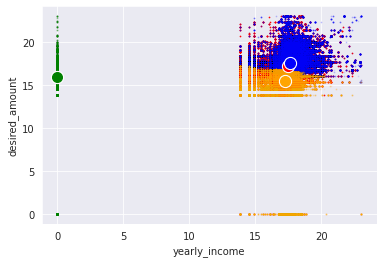

In [ ]:
#군집화 결과 시각화, 다른 변수들도 이용했으므로 2차원 상에서는 경향성 차이만 확인됨.
import matplotlib.pyplot as plt
plt.scatter(group0['yearly_income'],group0['desired_amount'], color = 'red', alpha = 1, s=0.5)
plt.scatter(group1['yearly_income'],group1['desired_amount'], color = 'blue', alpha = 0.1, s=0.5)
plt.scatter(group2['yearly_income'],group2['desired_amount'], color = 'orange', alpha = 0.1, s=0.5)
plt.scatter(group3['yearly_income'],group3['desired_amount'], color = 'green', alpha = 0.1, s=0.5)
plt.scatter(groups.cluster_centers_[0][0],groups.cluster_centers_[0][1], color = 'white', s=150)
plt.scatter(groups.cluster_centers_[0][0],groups.cluster_centers_[0][1], color = 'red', s=100)
plt.scatter(groups.cluster_centers_[1][0],groups.cluster_centers_[1][1], color = 'white', s=150)
plt.scatter(groups.cluster_centers_[1][0],groups.cluster_centers_[1][1], color = 'blue', s=100)
plt.scatter(groups.cluster_centers_[2][0],groups.cluster_centers_[2][1], color = 'white', s=150)
plt.scatter(groups.cluster_centers_[2][0],groups.cluster_centers_[2][1], color = 'orange', s=100)
plt.scatter(groups.cluster_centers_[3][0],groups.cluster_centers_[3][1], color = 'white', s=150)
plt.scatter(groups.cluster_centers_[3][0],groups.cluster_centers_[3][1], color = 'green', s=100)
plt.xlabel('yearly_income')
plt.ylabel('desired_amount')
plt.show()

In [ ]:
train_loan5.isnull().sum()

application_id                 0
product_id                     0
loan_limit                     0
loan_rate                      0
is_applied                     0
user_id                        0
birth_year                     0
gender                         0
insert_time                    0
credit_score                   0
yearly_income                  0
company_enter_month            0
desired_amount                 0
existing_loan_cnt              0
existing_loan_amt              0
rehabilitation_complete        0
rehabilitation_incomplete      0
income_type_EARNEDINCOME       0
income_type_EARNEDINCOME2      0
income_type_FREELANCER         0
income_type_OTHERINCOME        0
income_type_PRIVATEBUSINESS    0
employment_type_기타             0
employment_type_정규직            0
houseown_type_기타가족소유           0
houseown_type_자가               0
purpose_대환대출                   0
purpose_생활비                    0
purpose_전월세보증금                 0
purpose_주택구입                   0
group     

In [ ]:
test_loan3[cols].isnull().sum()

yearly_income           0
desired_amount          0
houseown_type_자가        0
houseown_type_기타가족소유    0
loan_limit              0
dtype: int64

In [ ]:
test_loan3[cols] = test_loan3[cols].fillna(np.median(train_loan3['yearly_income']))
group_test = groups.predict(test_loan3[cols])
test_loan3['group'] = group_test
test_loan3['group'].value_counts()

1    1550625
2     868751
0     815194
3      20732
Name: group, dtype: int64

In [ ]:
group0 = test_loan3[test_loan3['group']==0]
group1 = test_loan3[test_loan3['group']==1]
group2 = test_loan3[test_loan3['group']==2]
group3 = test_loan3[test_loan3['group']==3]

for i in train_na:
  group0[i].fillna(np.nanmedian(group0[i]), inplace = True)
  group1[i].fillna(np.nanmedian(group1[i]), inplace = True)
  group2[i].fillna(np.nanmedian(group2[i]), inplace = True)
  group3[i].fillna(np.nanmedian(group3[i]), inplace = True)

test_loan4 = pd.concat([group0, group1, group2, group3])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
test_loan4.isnull().sum()

application_id                       0
product_id                           0
loan_limit                           0
loan_rate                            0
is_applied                     3255302
user_id                              0
birth_year                           0
gender                               0
insert_time                          0
credit_score                         0
yearly_income                        0
company_enter_month                  0
desired_amount                       0
existing_loan_cnt                    0
existing_loan_amt                    0
rehabilitation_complete              0
rehabilitation_incomplete            0
income_type_EARNEDINCOME             0
income_type_EARNEDINCOME2            0
income_type_FREELANCER               0
income_type_OTHERINCOME              0
income_type_PRIVATEBUSINESS          0
employment_type_기타                   0
employment_type_정규직                  0
houseown_type_기타가족소유                 0
houseown_type_자가         

In [ ]:
print(train_loan4.shape, train_loan5.shape)
print(test_loan3.shape, test_loan4.shape)

(10263894, 31) (10263894, 31)
(3255302, 31) (3255302, 31)


###5.로그데이터 병합

In [ ]:
train_user = train_loan5[['user_id']]
test_user = test_loan4[['user_id']]

In [ ]:
#log_data의 event 변수 고유값 확인
log_data[['event']].value_counts()

event                  
OpenApp                    3460762
EndLoanApply               2715253
GetCreditInfo              2661997
Login                      2463755
StartLoanApply             1893914
ViewLoanApplyIntro         1804712
UseLoanManage              1558906
CompleteIDCertification    1237777
SignUp                       34892
UsePrepayCalc                 7360
UseDSRCalc                    4665
dtype: int64

In [ ]:
for i in list(log_data['event'].unique()):
  print(i)
  log_limit = log_data[log_data['event']==i]
  log_limit = log_limit[['user_id']]
  log_limit[i] = 1
  log_limit = log_limit.drop_duplicates(ignore_index = True)
  log_limit = log_limit.drop(log_limit[~log_limit['user_id'].isin(train_user['user_id'])].index)
  print(log_limit.shape)
  train_user = train_user.merge(log_limit, on='user_id', how='left')
  train_user = train_user.fillna(0)
  train_loan5[i] = train_user[i]
  train_user = train_loan5[['user_id']]

StartLoanApply
(205694, 2)
ViewLoanApplyIntro
(208407, 2)
EndLoanApply


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(211758, 2)
OpenApp
(199218, 2)
UseLoanManage
(159545, 2)
UsePrepayCalc
(3098, 2)
Login
(169612, 2)
CompleteIDCertification
(203151, 2)
UseDSRCalc
(2373, 2)
SignUp
(12463, 2)
GetCreditInfo
(205325, 2)


In [ ]:
cor3 = train_loan5[list(log_data['event'].unique())].corrwith(other = train_loan5['is_applied'])
cor3 = cor3.reset_index()
cor3.sort_values(0, ascending=False)

,index,0
5,UsePrepayCalc,0.000873
0,StartLoanApply,0.000655
1,ViewLoanApplyIntro,0.000466
4,UseLoanManage,0.000410
2,EndLoanApply,0.000404
9,SignUp,0.000366
7,CompleteIDCertification,0.000314
10,GetCreditInfo,0.000134
6,Login,0.000006
3,OpenApp,-0.000228


In [ ]:
cor4 = train_loan5[list(log_data['event'].unique())].corr()
cor4 = cor4.reset_index()
cor4.sort_values('EndLoanApply', ascending=True)

,index,StartLoanApply,ViewLoanApplyIntro,EndLoanApply,OpenApp,UseLoanManage,UsePrepayCalc,Login,CompleteIDCertification,UseDSRCalc,SignUp,GetCreditInfo
8,UseDSRCalc,0.040537,0.042612,0.039512,0.038881,0.075828,0.386670,-0.178210,0.044348,1.000000,0.010908,0.049751
5,UsePrepayCalc,0.043972,0.045944,0.042675,0.044560,0.082380,1.000000,-0.189228,0.047605,0.386670,0.010307,0.054171
9,SignUp,0.060695,0.070709,0.066435,0.072468,0.064056,0.010307,0.029790,0.076541,0.010908,1.000000,0.055727
10,GetCreditInfo,0.271371,0.307806,0.295387,0.377407,0.654059,0.054171,0.268638,0.298374,0.049751,0.055727,1.000000
6,Login,0.318501,0.316697,0.346811,0.373781,0.267335,-0.189228,1.000000,0.281802,-0.178210,0.029790,0.268638
4,UseLoanManage,0.425407,0.470512,0.454511,0.520713,1.000000,0.082380,0.267335,0.464910,0.075828,0.064056,0.654059
3,OpenApp,0.679581,0.714055,0.705592,1.000000,0.520713,0.044560,0.373781,0.694055,0.038881,0.072468,0.377407
1,ViewLoanApplyIntro,0.790614,1.000000,0.833273,0.714055,0.470512,0.045944,0.316697,0.938174,0.042612,0.070709,0.307806
0,StartLoanApply,1.000000,0.790614,0.845811,0.679581,0.425407,0.043972,0.318501,0.783492,0.040537,0.060695,0.271371
7,CompleteIDCertification,0.783492,0.938174,0.851621,0.694055,0.464910,0.047605,0.281802,1.000000,0.044348,0.076541,0.298374


In [ ]:
Use = ['EndLoanApply', 'UseLoanManage']
Not_Use = list(set(log_data['event'].unique()) - set(Use)) 
train_loan6 = train_loan5.drop(Not_Use, axis=1)
train_loan6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10263894 entries, 1 to 10263570
Data columns (total 33 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   application_id               int64  
 1   product_id                   int64  
 2   loan_limit                   float64
 3   loan_rate                    float64
 4   is_applied                   float64
 5   user_id                      float64
 6   birth_year                   float64
 7   gender                       float64
 8   insert_time                  int64  
 9   credit_score                 float64
 10  yearly_income                float64
 11  company_enter_month          float64
 12  desired_amount               float64
 13  existing_loan_cnt            float64
 14  existing_loan_amt            float64
 15  rehabilitation_complete      int64  
 16  rehabilitation_incomplete    int64  
 17  income_type_EARNEDINCOME     int64  
 18  income_type_EARNEDINCOME2    int64  
 19

In [ ]:
for i in Use:
  print(i)
  test_user = test_loan4[['user_id']]
  log_limit = log_data[log_data['event']==i]
  log_limit = log_limit[['user_id']]
  log_limit[i] = 1
  log_limit = log_limit.drop_duplicates(ignore_index = True)
  log_limit = log_limit.drop(log_limit[~log_limit['user_id'].isin(train_user['user_id'])].index)
  print(log_limit.shape)
  test_user = test_user.merge(log_limit, on='user_id', how='left')
  test_user = test_user.fillna(0)
  test_loan4[i] = test_user[i]

EndLoanApply
(211758, 2)
UseLoanManage
(159545, 2)


In [ ]:
test_loan4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3255302 entries, 4 to 3253432
Data columns (total 33 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   application_id               int64  
 1   product_id                   int64  
 2   loan_limit                   float64
 3   loan_rate                    float64
 4   is_applied                   float64
 5   user_id                      int64  
 6   birth_year                   float64
 7   gender                       float64
 8   insert_time                  int64  
 9   credit_score                 float64
 10  yearly_income                float64
 11  company_enter_month          float64
 12  desired_amount               float64
 13  existing_loan_cnt            float64
 14  existing_loan_amt            float64
 15  rehabilitation_complete      int64  
 16  rehabilitation_incomplete    int64  
 17  income_type_EARNEDINCOME     int64  
 18  income_type_EARNEDINCOME2    int64  
 19  

###6. 기초 예측

####5-2. 타겟변수 세팅

In [ ]:
#테스트셋에서 타겟 제거
test_loan5 = test_loan4.drop(columns=['is_applied'])

In [ ]:
#결측치 개수 확인
test_loan5.isnull().sum()

####5-4. 로지스틱 회귀 & 랜덤 포레스트

In [ ]:
train_y = train_loan6['is_applied']
train_y.value_counts()

0.0    9709403
1.0     554491
Name: is_applied, dtype: int64

In [ ]:
train_loan7 = train_loan6.drop('is_applied',axis=1)

In [ ]:
# 이후 최종 모델링을 위해 전처리 완료한 데이터셋 저장
train_loan6.to_csv("train.csv")
test_loan4.to_csv("test.csv")

In [ ]:
#train, test 분리 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_loan7, train_y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [ ]:
#학습, 테스트 데이터의 크기 재확인
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (7184725, 32)
Shape of X_test:  (3079169, 32)
Shape of y_train:  (7184725,)
Shape of y_test (3079169,)


In [ ]:
# 타겟 변수 불균형 해결 위해 SMOTE 적용
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_smote.shape, y_train_smote.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_smote).value_counts())

SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (13592760, 32) (13592760,)
SMOTE 적용 후 레이블 값 분포: 
 0.0    6796380
1.0    6796380
Name: is_applied, dtype: int64


In [ ]:
print('테스트셋 레이블 값 분포: \n', pd.Series(y_test).value_counts()/len(y_test))

테스트셋 레이블 값 분포: 
 0.0    0.946042
1.0    0.053958
Name: is_applied, dtype: float64


In [ ]:
#분석에 앞서 타겟과의 상관관계 체크(train)
X_train_smote.corrwith(y_train_smote)

application_id                -0.000366
product_id                     0.079297
loan_limit                    -0.046271
loan_rate                     -0.119394
user_id                       -0.000264
birth_year                     0.031604
gender                        -0.028689
insert_time                    0.010582
credit_score                  -0.396891
yearly_income                 -0.082174
company_enter_month            0.094179
desired_amount                -0.284097
existing_loan_cnt              0.170994
existing_loan_amt             -0.042775
rehabilitation_complete       -0.007810
rehabilitation_incomplete     -0.144787
income_type_EARNEDINCOME      -0.384179
income_type_EARNEDINCOME2     -0.022692
income_type_FREELANCER        -0.044232
income_type_OTHERINCOME       -0.031467
income_type_PRIVATEBUSINESS   -0.070264
employment_type_기타            -0.030983
employment_type_정규직           -0.331745
houseown_type_기타가족소유          -0.139942
houseown_type_자가              -0.263870


In [ ]:
#분석에 앞서 타겟과의 상관관계 체크(test)
X_test.corrwith(y_test)

application_id                 0.001880
product_id                     0.034823
loan_limit                    -0.018457
loan_rate                     -0.051568
user_id                        0.001166
birth_year                     0.010586
gender                        -0.012315
insert_time                    0.008068
credit_score                  -0.168619
yearly_income                 -0.038684
company_enter_month            0.031697
desired_amount                -0.123178
existing_loan_cnt              0.078976
existing_loan_amt             -0.015633
rehabilitation_complete        0.001983
rehabilitation_incomplete      0.002816
income_type_EARNEDINCOME      -0.114155
income_type_EARNEDINCOME2      0.061460
income_type_FREELANCER         0.051336
income_type_OTHERINCOME        0.075457
income_type_PRIVATEBUSINESS    0.039502
employment_type_기타             0.093301
employment_type_정규직           -0.080468
houseown_type_기타가족소유           0.031129
houseown_type_자가              -0.034054


In [ ]:
#로지스틱 회귀 학습 및 예측
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
lr = LogisticRegression()
lr.fit(X_train_smote, y_train_smote)
lr_predict = lr.predict(X_test)

In [ ]:
#오차행렬 및 정확도 출력
from sklearn.metrics import f1_score
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
lr_f1_score = f1_score(y_test, lr_predict)
print(lr_conf_matrix)
print("정확도: ", lr_acc_score*100, "\nF1 score:", lr_f1_score)

[[1776334 1136689]
 [  46381  119765]]
정확도:  61.57826998128391 
F1 score: 0.16837480669197244


In [ ]:
#랜덤 포레스트 학습 및 예측
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train_smote, y_train_smote)
rf_predict=rf.predict(X_test)

In [ ]:
#오차행렬 및 정확도 출력
rf_conf_matrix = confusion_matrix(y_test, rf_predict)
rf_acc_score = accuracy_score(y_test, rf_predict)
rf_f1_score = f1_score(y_test, rf_predict)
print(rf_conf_matrix)
print("정확도: ", rf_acc_score*100, "\nF1 score:", rf_f1_score)

[[2870639   42384]
 [ 135468   30678]]
정확도:  94.22402602780166 
F1 score: 0.25649643824621243


### 7. 모델링

#### 7-1. zero/one split

‘0’ label을 가진 데이터들을 20분할 후 ‘1’ label 데이터와 중복으로 concat 해서 ‘0’, ‘1’ 간 밸런스를 맞춤과 동시에 각 학습 데이터의 사이즈를 줄여 Auto-ML이 잘 돌아가지 않았던 문제를 해결


In [ ]:
train = pd.read_csv(r'/content/drive/MyDrive/22-2 KUBIG 분류 예측 1팀/B팀/train.csv')

In [ ]:
train.head()

,Unnamed: 0,application_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,...,employment_type_정규직,houseown_type_기타가족소유,houseown_type_자가,purpose_대환대출,purpose_생활비,purpose_전월세보증금,purpose_주택구입,group,EndLoanApply,UseLoanManage
0,0,2136706,169,16.906553,15.9,0.0,558819.0,1983.0,1.0,69,...,1,0,0,1,0,0,0,0,1.0,1.0
1,1,2136706,36,17.249498,16.6,0.0,558819.0,1983.0,1.0,69,...,1,0,0,1,0,0,0,0,1.0,1.0
2,2,2136706,222,17.479072,12.4,0.0,558819.0,1983.0,1.0,69,...,1,0,0,1,0,0,0,0,1.0,1.0
3,3,2136706,114,17.216708,14.8,0.0,558819.0,1983.0,1.0,69,...,1,0,0,1,0,0,0,0,1.0,1.0
4,4,2136706,223,16.705882,13.3,0.0,558819.0,1983.0,1.0,69,...,1,0,0,1,0,0,0,0,1.0,1.0


In [ ]:
train.columns

Index(['Unnamed: 0', 'application_id', 'product_id', 'loan_limit', 'loan_rate',
       'is_applied', 'user_id', 'birth_year', 'gender', 'insert_time',
       'credit_score', 'yearly_income', 'company_enter_month',
       'desired_amount', 'existing_loan_cnt', 'existing_loan_amt',
       'rehabilitation_complete', 'rehabilitation_incomplete',
       'income_type_EARNEDINCOME', 'income_type_EARNEDINCOME2',
       'income_type_FREELANCER', 'income_type_OTHERINCOME',
       'income_type_PRIVATEBUSINESS', 'employment_type_기타',
       'employment_type_정규직', 'houseown_type_기타가족소유', 'houseown_type_자가',
       'purpose_대환대출', 'purpose_생활비', 'purpose_전월세보증금', 'purpose_주택구입',
       'group', 'EndLoanApply', 'UseLoanManage'],
      dtype='object')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
train.shape

(10263894, 34)

In [ ]:
train.head()

,Unnamed: 0,application_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,credit_score,yearly_income,company_enter_month,desired_amount,existing_loan_cnt,existing_loan_amt,rehabilitation_complete,rehabilitation_incomplete,income_type_EARNEDINCOME,income_type_EARNEDINCOME2,income_type_FREELANCER,income_type_OTHERINCOME,income_type_PRIVATEBUSINESS,employment_type_기타,employment_type_정규직,houseown_type_기타가족소유,houseown_type_자가,purpose_대환대출,purpose_생활비,purpose_전월세보증금,purpose_주택구입,group,EndLoanApply,UseLoanManage
0,0,2136706,169,16.906553,15.9,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
1,1,2136706,36,17.249498,16.6,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
2,2,2136706,222,17.479072,12.4,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
3,3,2136706,114,17.216708,14.8,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
4,4,2136706,223,16.705882,13.3,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0


In [ ]:
train[train["EndLoanApply"]==0.0]

,Unnamed: 0,application_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,credit_score,yearly_income,company_enter_month,desired_amount,existing_loan_cnt,existing_loan_amt,rehabilitation_complete,rehabilitation_incomplete,income_type_EARNEDINCOME,income_type_EARNEDINCOME2,income_type_FREELANCER,income_type_OTHERINCOME,income_type_PRIVATEBUSINESS,employment_type_기타,employment_type_정규직,houseown_type_기타가족소유,houseown_type_자가,purpose_대환대출,purpose_생활비,purpose_전월세보증금,purpose_주택구입,group,EndLoanApply,UseLoanManage
207,207,1756892,19,16.300417,17.7,0.0,501279.0,1983.0,1.0,69,650.0,18.064006,10497.0,17.727534,1.098612,17.785802,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0
208,208,1756892,149,17.840862,13.9,0.0,501279.0,1983.0,1.0,69,650.0,18.064006,10497.0,17.727534,1.098612,17.785802,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0
209,209,1756892,142,16.588099,15.1,0.0,501279.0,1983.0,1.0,69,650.0,18.064006,10497.0,17.727534,1.098612,17.785802,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0
210,210,1756892,200,17.281246,9.3,1.0,501279.0,1983.0,1.0,69,650.0,18.064006,10497.0,17.727534,1.098612,17.785802,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0
211,211,1756892,168,16.523561,14.5,0.0,501279.0,1983.0,1.0,69,650.0,18.064006,10497.0,17.727534,1.098612,17.785802,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263635,10263635,1547588,195,16.759950,9.0,0.0,91277.0,1999.0,1.0,76,680.0,16.118096,10895.0,16.118096,1.386294,17.341871,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,3,0.0,0.0
10263636,10263636,1547588,136,16.759950,6.5,0.0,91277.0,1999.0,1.0,76,680.0,16.118096,10895.0,16.118096,1.386294,17.341871,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,3,0.0,0.0
10263637,10263637,1547588,257,16.759950,7.2,0.0,91277.0,1999.0,1.0,76,680.0,16.118096,10895.0,16.118096,1.386294,17.341871,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,3,0.0,0.0
10263638,10263638,1547588,224,17.974394,13.7,0.0,91277.0,1999.0,1.0,76,680.0,16.118096,10895.0,16.118096,1.386294,17.341871,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,3,0.0,0.0


In [ ]:
train['is_applied'].value_counts()

0.0    9709403
1.0     554491
Name: is_applied, dtype: int64

In [ ]:
#타겟변수 is_applied가 0이면 zeroes, 1이면 ones
zeroes = train[train['is_applied']==0.0]
ones = train[train['is_applied']==1.0]   

In [ ]:
zeroes

,Unnamed: 0,application_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,credit_score,yearly_income,company_enter_month,desired_amount,existing_loan_cnt,existing_loan_amt,rehabilitation_complete,rehabilitation_incomplete,income_type_EARNEDINCOME,income_type_EARNEDINCOME2,income_type_FREELANCER,income_type_OTHERINCOME,income_type_PRIVATEBUSINESS,employment_type_기타,employment_type_정규직,houseown_type_기타가족소유,houseown_type_자가,purpose_대환대출,purpose_생활비,purpose_전월세보증금,purpose_주택구입,group,EndLoanApply,UseLoanManage
0,0,2136706,169,16.906553,15.9,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
1,1,2136706,36,17.249498,16.6,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
2,2,2136706,222,17.479072,12.4,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
3,3,2136706,114,17.216708,14.8,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
4,4,2136706,223,16.705882,13.3,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263889,10263889,1369315,148,16.705882,7.0,0.0,601384.0,1977.0,0.0,76,600.0,17.370859,11000.0,15.607270,1.386294,17.111347,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,3,1.0,0.0
10263890,10263890,1369315,257,16.705882,7.2,0.0,601384.0,1977.0,0.0,76,600.0,17.370859,11000.0,15.607270,1.386294,17.111347,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,3,1.0,0.0
10263891,10263891,1369315,31,16.588099,9.9,0.0,601384.0,1977.0,0.0,76,600.0,17.370859,11000.0,15.607270,1.386294,17.111347,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,3,1.0,0.0
10263892,10263892,1369315,39,17.216708,15.1,0.0,601384.0,1977.0,0.0,76,600.0,17.370859,11000.0,15.607270,1.386294,17.111347,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,3,1.0,0.0


In [ ]:
ones

,Unnamed: 0,application_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,credit_score,yearly_income,company_enter_month,desired_amount,existing_loan_cnt,existing_loan_amt,rehabilitation_complete,rehabilitation_incomplete,income_type_EARNEDINCOME,income_type_EARNEDINCOME2,income_type_FREELANCER,income_type_OTHERINCOME,income_type_PRIVATEBUSINESS,employment_type_기타,employment_type_정규직,houseown_type_기타가족소유,houseown_type_자가,purpose_대환대출,purpose_생활비,purpose_전월세보증금,purpose_주택구입,group,EndLoanApply,UseLoanManage
12,12,2136706,236,17.426428,9.9,1.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
16,16,2136706,200,16.454568,9.3,1.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
19,19,2136706,61,16.380460,8.9,1.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
118,118,1637434,234,17.216708,3.9,1.0,253258.0,1994.0,1.0,69,910.0,17.216708,10992.0,17.727534,1.098612,17.785802,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,0.0
147,147,1637434,268,17.426428,5.7,1.0,253258.0,1994.0,1.0,69,910.0,17.216708,10992.0,17.727534,1.098612,17.785802,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263812,10263812,115505,85,16.811243,14.3,1.0,585871.0,1992.0,0.0,76,660.0,16.300417,11094.0,14.914123,0.693147,17.341871,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,3,1.0,1.0
10263819,10263819,115505,224,16.300417,12.3,1.0,585871.0,1992.0,0.0,76,660.0,16.300417,11094.0,14.914123,0.693147,17.341871,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,3,1.0,1.0
10263877,10263877,190135,150,16.012735,17.7,1.0,879596.0,1980.0,1.0,76,610.0,17.875954,9602.0,14.914123,0.693147,17.341871,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,3,1.0,1.0
10263880,10263880,1369315,136,16.705882,6.5,1.0,601384.0,1977.0,0.0,76,600.0,17.370859,11000.0,15.607270,1.386294,17.111347,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,3,1.0,0.0


In [ ]:
#pycaret 을 사용하기 위해 필요한 것들
!pip install markupsafe==2.0.1
!pip install Jinja2
import jinja2
!pip install pycaret
#pycaret 설치

In [ ]:
from pycaret.classification import *
"""clf = setup(
    data = df,
    target = 'is_applied',
    n_jobs=1
)"""

#best_3 = compare_models(sort = 'AUC', n_select = 3)

In [ ]:
z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20 = np.array_split(zeroes, 20)

In [ ]:
z1

,Unnamed: 0,application_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,credit_score,yearly_income,company_enter_month,desired_amount,existing_loan_cnt,existing_loan_amt,rehabilitation_complete,rehabilitation_incomplete,income_type_EARNEDINCOME,income_type_EARNEDINCOME2,income_type_FREELANCER,income_type_OTHERINCOME,income_type_PRIVATEBUSINESS,employment_type_기타,employment_type_정규직,houseown_type_기타가족소유,houseown_type_자가,purpose_대환대출,purpose_생활비,purpose_전월세보증금,purpose_주택구입,group,EndLoanApply,UseLoanManage
0,0,2136706,169,16.906553,15.9,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
1,1,2136706,36,17.249498,16.6,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
2,2,2136706,222,17.479072,12.4,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
3,3,2136706,114,17.216708,14.8,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
4,4,2136706,223,16.705882,13.3,0.0,558819.0,1983.0,1.0,69,740.0,17.479072,10094.0,18.197537,1.098612,17.875954,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503099,503099,373587,149,17.281246,12.2,0.0,364514.0,1983.0,1.0,29,740.0,17.281246,10694.0,16.811243,0.693147,16.759950,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
503100,503100,373587,224,17.504390,13.8,0.0,364514.0,1983.0,1.0,29,740.0,17.281246,10694.0,16.811243,0.693147,16.759950,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
503101,503101,373587,236,17.182806,12.6,0.0,364514.0,1983.0,1.0,29,740.0,17.281246,10694.0,16.811243,0.693147,16.759950,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0
503102,503102,373587,19,16.648724,15.0,0.0,364514.0,1983.0,1.0,29,740.0,17.281246,10694.0,16.811243,0.693147,16.759950,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0


In [ ]:
z1.to_csv('/content/drive/MyDrive/z1.csv')
z2.to_csv('/content/drive/MyDrive/z2.csv')
z3.to_csv('/content/drive/MyDrive/z3.csv')
z4.to_csv('/content/drive/MyDrive/z4.csv')
z5.to_csv('/content/drive/MyDrive/z5.csv')
z6.to_csv('/content/drive/MyDrive/z6.csv')
z7.to_csv('/content/drive/MyDrive/z7.csv')
z8.to_csv('/content/drive/MyDrive/z8.csv')
z9.to_csv('/content/drive/MyDrive/z9.csv')
z10.to_csv('/content/drive/MyDrive/z10.csv')
z11.to_csv('/content/drive/MyDrive/z11.csv')
z12.to_csv('/content/drive/MyDrive/z12.csv')
z13.to_csv('/content/drive/MyDrive/z13.csv')
z14.to_csv('/content/drive/MyDrive/z14.csv')
z15.to_csv('/content/drive/MyDrive/z15.csv')
z16.to_csv('/content/drive/MyDrive/z16.csv')
z17.to_csv('/content/drive/MyDrive/z17.csv')
z18.to_csv('/content/drive/MyDrive/z18.csv')
z19.to_csv('/content/drive/MyDrive/z19.csv')
z20.to_csv('/content/drive/MyDrive/z20.csv')

In [ ]:
ones.to_csv('/content/drive/MyDrive/ones.csv')

#### 7-2. pdconcat

In [ ]:
z1 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z1.csv')
z2 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z2.csv')
z3 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z3.csv')
z4 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z4.csv')
z5 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z5.csv')
z6 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z6.csv')
z7 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z7.csv')
z8 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z8.csv')
z9 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z9.csv')
z10 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z10.csv')
z11 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z11.csv')
z12 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z12.csv')
z13 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z13.csv')
z14 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z14.csv')
z15 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z15.csv')
z16 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z16.csv')
z17 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z17.csv')
z18 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z18.csv')
z19 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z19.csv')
z20 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z20.csv')

In [ ]:
ones= pd.read_csv(r'/content/drive/MyDrive/ones.csv')

In [ ]:
zeroes = [z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20]

In [ ]:
# z1~z20에 각각 ones를 연결하여 다시 z1~z20으로 지정 
z1 = pd.concat([z1,ones])
z1

In [ ]:
z1.to_csv('/content/drive/MyDrive/zeroes/z1.csv')

In [ ]:
z2 = pd.concat([z2,ones])
z2.to_csv('/content/drive/MyDrive/zeroes/z2.csv')

In [ ]:
z3 = pd.concat([z3,ones])
z3.to_csv('/content/drive/MyDrive/zeroes/z3.csv')

In [ ]:
z4 = pd.concat([z4,ones])
z4.to_csv('/content/drive/MyDrive/zeroes/z4.csv')

In [ ]:
z5 = pd.concat([z5,ones])
z5.to_csv('/content/drive/MyDrive/zeroes/z5.csv')

In [ ]:
z6 = pd.concat([z6,ones])
z6.to_csv('/content/drive/MyDrive/zeroes/z6.csv')

In [ ]:
z7 = pd.concat([z7,ones])
z7.to_csv('/content/drive/MyDrive/zeroes/z7.csv')

In [ ]:
z8 = pd.concat([z8,ones])
z8.to_csv('/content/drive/MyDrive/zeroes/z8.csv')

In [ ]:
z9 = pd.concat([z9,ones])
z9.to_csv('/content/drive/MyDrive/zeroes/z9.csv')

In [ ]:
z10 = pd.concat([z10,ones])
z10.to_csv('/content/drive/MyDrive/zeroes/z10.csv')

In [ ]:
z11 = pd.concat([z11,ones])
z11.to_csv('/content/drive/MyDrive/zeroes/z11.csv')

In [ ]:
z12 = pd.concat([z12,ones])
z12.to_csv('/content/drive/MyDrive/zeroes/z12.csv')

In [ ]:
z13 = pd.concat([z13,ones])
z13.to_csv('/content/drive/MyDrive/zeroes/z13.csv')

In [ ]:
z14 = pd.concat([z14,ones])
z14.to_csv('/content/drive/MyDrive/zeroes/z14.csv')

In [ ]:
z15 = pd.concat([z15,ones])
z15.to_csv('/content/drive/MyDrive/zeroes/z15.csv')

In [ ]:
z16 = pd.concat([z16,ones])
z16.to_csv('/content/drive/MyDrive/zeroes/z16.csv')

In [ ]:
z17 = pd.concat([z17,ones])
z17.to_csv('/content/drive/MyDrive/zeroes/z17.csv')

In [ ]:
z18 = pd.concat([z18,ones])
z18.to_csv('/content/drive/MyDrive/zeroes/z18.csv')

In [ ]:
z19 = pd.concat([z19,ones])
z19.to_csv('/content/drive/MyDrive/zeroes/z19.csv')

In [ ]:
z20 = pd.concat([z20,ones])
z20.to_csv('/content/drive/MyDrive/zeroes/z20.csv')

#### 7-3.predict(z1기준, z20까지 바꿔가며 시행)

##### 1차 시행

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#pycaret 을 사용하기 위해 필요한 것들
!pip install markupsafe==2.0.1
!pip install Jinja2
import jinja2
!pip install pycaret
#pycaret 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 5.2 MB/s 
     |████████████████████████████████| 167 kB 58.6 MB/s 
     |████████████████████████████████| 137 kB 59.6 MB/s 
     |████████████████████████████████| 268 kB 67.1 MB/s 
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 16.9 MB 58.2 MB/s 
     |████████████████████████████████| 3.3 MB 22.9 MB/s 
     |████████████████████████████████| 636 kB 37.2 MB/s 
     |████████████████████████████████| 6.8 MB 23.9 MB/s 
     |████████████████████████████████| 1.3 MB 43.1 MB/s 
     |████████████████████████████████| 2.0 MB 32.0 MB/s 
     |████████████████████████████████| 1.7 MB 55.7 MB/s 
  Install

##### 2차 시행

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#Z에 따라 불러오는 z수정
z1 = pd.read_csv(r'/content/drive/MyDrive/zeroes/z7.csv')
z1.drop(['Unnamed: 0','Unnamed: 0.1', 'Unnamed: 0.1.1'],axis = 1, inplace = True) 

In [ ]:
#pycaret 을 사용하기 위해 필요한 것들
!pip install markupsafe==2.0.1
!pip install Jinja2
import jinja2
!pip install pycaret
#pycaret 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycaret.classification import *

In [ ]:
# z수정
clf = setup(
    data = z1,
    target = 'is_applied',
    n_jobs=1,
    fold=3
)

,Description,Value
0,session_id,1635
1,Target,is_applied
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(1039961, 33)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,19
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='is_applied', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_s...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [ ]:
best_3 = compare_models(sort = 'f1', include = ['dt', 'rf', 'et'], n_select = 3, fold=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9422,0.9906,0.9170,0.9730,0.9442,0.8843,0.8860,97.2500
rf,Random Forest Classifier,0.9383,0.9891,0.9138,0.9687,0.9404,0.8765,0.8781,134.3167
dt,Decision Tree Classifier,0.9304,0.9305,0.9286,0.9401,0.9343,0.8602,0.8603,8.0300


INFO:logs:create_model_container: 3
INFO:logs:master_model_container: 3
INFO:logs:display_container: 2
INFO:logs:[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                     oob_score=False, random_state=1635, verbose=0,
                     warm_start=False), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
    

In [ ]:
blended = blend_models(estimator_list = best_3, fold = 3, method = 'soft',optimize = 'f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.9900,0.9292,0.9617,0.9452,0.8848,0.8854
1,0.9455,0.9905,0.9324,0.9642,0.9480,0.8907,0.8913
2,0.9443,0.9902,0.9308,0.9634,0.9468,0.8883,0.8889
Mean,0.9441,0.9902,0.9308,0.9631,0.9467,0.8879,0.8885
Std,0.0012,0.0002,0.0013,0.0010,0.0012,0.0024,0.0024


INFO:logs:create_model_container: 4
INFO:logs:master_model_container: 4
INFO:logs:display_container: 3
INFO:logs:VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
 

In [ ]:
final_model = finalize_model(blended)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                       

In [ ]:
save_model(final_model, 'my_final_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='is_applied', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_s...
                                                                       class_weight=None,
                                                                       criterion='gini',
                                                                       max_depth=None,
        

##### 3차 시행

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#pycaret 을 사용하기 위해 필요한 것들
!pip install markupsafe==2.0.1
!pip install Jinja2
import jinja2
!pip install pycaret
#pycaret 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycaret.classification import *

In [ ]:
loaded_model = load_model('my_final_model')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=my_final_model, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


In [ ]:
test = pd.read_csv(r'/content/drive/MyDrive/22-2 KUBIG 분류 예측 1팀/B팀/test.csv')

In [ ]:
test.shape

(3255302, 34)

In [ ]:
test.drop(['Unnamed: 0'], axis=1,inplace = True)

In [ ]:
import numpy as np

In [ ]:
t1,t2,t3,t4,t5 = np.array_split(test, 5)

In [ ]:
predictions = predict_model(loaded_model, data = t1,raw_score = True)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='classification',
                                      target='is_applied')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',...
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                ('dfs', 'passthrough'), ('pca', 'passthrough'),
                ['trained_model',
      

In [ ]:
predictions

,application_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,credit_score,yearly_income,company_enter_month,desired_amount,existing_loan_cnt,existing_loan_amt,rehabilitation_complete,rehabilitation_incomplete,income_type_EARNEDINCOME,income_type_EARNEDINCOME2,income_type_FREELANCER,income_type_OTHERINCOME,income_type_PRIVATEBUSINESS,employment_type_기타,employment_type_정규직,houseown_type_기타가족소유,houseown_type_자가,purpose_대환대출,purpose_생활비,purpose_전월세보증금,purpose_주택구입,group,EndLoanApply,UseLoanManage,Label,Score_0.0,Score_1.0
0,1748340,191,17.553180,13.6,NaN,430982,1996.0,1.0,98,620.0,16.993564,20220201.0,17.034386,1.098612,16.523561,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1.0,1.0,1.0,0.0767,0.9233
1,1748340,169,16.993564,17.9,NaN,430982,1996.0,1.0,98,620.0,16.993564,20220201.0,17.034386,1.098612,16.523561,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1.0,1.0,1.0,0.1533,0.8467
2,1748340,7,16.993564,18.5,NaN,430982,1996.0,1.0,98,620.0,16.993564,20220201.0,17.034386,1.098612,16.523561,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1.0,1.0,1.0,0.1567,0.8433
3,1748340,268,17.182806,10.8,NaN,430982,1996.0,1.0,98,620.0,16.993564,20220201.0,17.034386,1.098612,16.523561,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1.0,1.0,1.0,0.0767,0.9233
4,1748340,168,16.860033,15.2,NaN,430982,1996.0,1.0,98,620.0,16.993564,20220201.0,17.034386,1.098612,16.523561,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1.0,1.0,1.0,0.1267,0.8733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651056,1274270,268,18.159316,11.1,NaN,638719,1991.0,1.0,11,800.0,18.258162,20220201.0,20.723266,0.693147,15.761421,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0,0.0,0.6400,0.3600
651057,1274270,262,17.341871,17.5,NaN,638719,1991.0,1.0,11,800.0,18.258162,20220201.0,20.723266,0.693147,15.761421,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0,1.0,0.3133,0.6867
651058,1274270,149,18.064006,13.9,NaN,638719,1991.0,1.0,11,800.0,18.258162,20220201.0,20.723266,0.693147,15.761421,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0,1.0,0.3133,0.6867
651059,1274270,61,17.576711,10.4,NaN,638719,1991.0,1.0,11,800.0,18.258162,20220201.0,20.723266,0.693147,15.761421,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0,0.0,0.6800,0.3200


In [ ]:
predictions2 = predict_model(loaded_model, data = t2,raw_score = True)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='classification',
                                      target='is_applied')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',...
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                ('dfs', 'passthrough'), ('pca', 'passthrough'),
                ['trained_model',
      

In [ ]:
predictions3 = predict_model(loaded_model, data = t3,raw_score = True)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='classification',
                                      target='is_applied')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',...
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                ('dfs', 'passthrough'), ('pca', 'passthrough'),
                ['trained_model',
      

In [ ]:
predictions4 = predict_model(loaded_model, data = t4,raw_score = True)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='classification',
                                      target='is_applied')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',...
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                ('dfs', 'passthrough'), ('pca', 'passthrough'),
                ['trained_model',
      

In [ ]:
predictions5 = predict_model(loaded_model, data = t5,raw_score = True)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='classification',
                                      target='is_applied')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',...
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                ('dfs', 'passthrough'), ('pca', 'passthrough'),
                ['trained_model',
      

In [ ]:
predictionst = pd.concat([predictions,predictions2,predictions3,predictions4,predictions5])

In [ ]:
# z 수정
pred1 = pd.DataFrame(columns=['z1'])
pred1['z1'] = predictionst['Score_1.0']
pred1.to_csv(r'/content/drive/MyDrive/pred7.csv') #pred z 따라 수정

#### 7-4.final(다른 파일에서 실행함)

In [ ]:
t1= pd.read_csv(r'/content/drive/MyDrive/pred1.csv')
t2 = pd.read_csv(r'/content/drive/MyDrive/pred2.csv')
#이후로 t20까지 추가후 rounding 

In [ ]:
t1

In [ ]:
t2

In [ ]:
final = pd.DataFrame(columns = ['mean'])

In [ ]:
final['mean'] = (t1['z1']+t2['z2'])/2

In [ ]:
final

In [ ]:
final = final.round()

In [ ]:
final

In [ ]:
test = pd.read_csv(r'/content/drive/MyDrive/test.csv')

In [ ]:
test

In [ ]:
test['is_applied'] = final

In [ ]:
submission = test[['application_id', 'product_id', 'is_applied']]

In [ ]:
submission